In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

# Handle Train Data

In [19]:
train_data = pd.read_csv("train.csv")
print("Total missing entrances: ", train_data[train_data.isna().any(axis=1)].shape[0])
print("Missing columns: ", list(train_data.columns[train_data.isna().any(axis=0)]))


train_data.drop(['id'], axis=1, inplace=True)
train_data.index.name = 'id'
train_data.dropna(inplace=True)

Total missing entrances:  2
Missing columns:  ['purchase_date', 'total_positive_reviews', 'total_negative_reviews']


## Transformation

In [20]:
def transform(data):
    data['purchase_year'] = pd.DatetimeIndex(data['purchase_date']).year
    data['purchase_month'] = pd.DatetimeIndex(data['purchase_date']).month
    data['release_year'] = pd.DatetimeIndex(data['release_date']).year
    data['release_month'] = pd.DatetimeIndex(data['release_date']).month
    data['wait_until_buy'] = (pd.to_datetime(data['purchase_date']) - pd.to_datetime(data['release_date'])).dt.days
    
    data['Num of genres'] = data['genres'].apply(lambda x: len(x.split(',')))
    data['Num of categories'] = data['categories'].apply(lambda x: len(x.split(',')))
    data['Num of tags'] =  data['tags'].apply(lambda x: len(x.split(',')))

    genres_one_hot = data['genres'].str.get_dummies(sep=',')
    categories_one_hot = data['categories'].str.get_dummies(sep=',')
    tags_one_hot = data['tags'].str.get_dummies(sep=',')
    
    data.drop(['genres', 'categories', 'tags', 'purchase_date', 'release_date', 'is_free'], axis=1, inplace=True)
    data = pd.concat([data, genres_one_hot, categories_one_hot, tags_one_hot], axis=1)
    
    data['reviews'] = data['total_positive_reviews'] + data['total_negative_reviews']
    
    data['positive_negative_ratio'] = data['total_positive_reviews']/(1+data['total_negative_reviews'])
    return data

In [21]:
train_data = transform(train_data)

## Rebuild the Categories and Genres Columns

In [22]:
# genres_col_train = ['Action', 'Adventure',
#                         'Animation & Modeling', 'Audio Production', 'Casual',
#                         'Design & Illustration', 'Early Access', 'Free to Play', 'Gore',
#                         'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
#                         'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Utilities',
#                         'Violent']
                               
                               
# categories_col_train = ['Captions available', 'Co-op', 'Commentary available',
#                         'Cross-Platform Multiplayer', 'Full controller support',
#                         'In-App Purchases', 'Includes Source SDK', 'Includes level editor',
#                         'Local Co-op', 'Local Multi-Player', 'MMO', 'Multi-player',
#                         'Online Co-op', 'Online Multi-Player', 'Partial Controller Support',
#                         'Remote Play on Phone', 'Remote Play on TV', 'Remote Play on Tablet',
#                         'Shared/Split Screen', 'Single-player', 'Stats', 'Steam Achievements',
#                         'Steam Cloud', 'Steam Leaderboards', 'Steam Trading Cards',
#                         'Steam Workshop', 'SteamVR Collectibles', 'VR Support',
#                         'Valve Anti-Cheat enabled']

# genres_col_test = ['Action', 'Adventure', 'Casual', 'Early Access', 'Free to Play', 'Gore',
#                     'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Simulation',
#                     'Sports', 'Strategy', 'Violent']
                              
                              
# categories_col_test = ['Captions available', 'Co-op',
#                         'Commentary available', 'Cross-Platform Multiplayer',
#                         'Full controller support', 'In-App Purchases', 'Includes Source SDK',
#                         'Includes level editor', 'Local Co-op', 'Local Multi-Player', 'MMO',
#                         'Multi-player', 'Online Co-op', 'Online Multi-Player',
#                         'Partial Controller Support', 'Remote Play on Phone',
#                         'Remote Play on TV', 'Remote Play on Tablet', 'Shared/Split Screen',
#                         'Single-player', 'Stats', 'Steam Achievements', 'Steam Cloud',
#                         'Steam Leaderboards', 'Steam Trading Cards', 'Steam Workshop',
#                         'SteamVR Collectibles', 'VR Support']

categories_col_train = pd.read_csv("train.csv")['categories'].str.get_dummies(sep=',').columns
categories_col_test = pd.read_csv("test.csv")['categories'].str.get_dummies(sep=',').columns
genres_col_train = pd.read_csv("train.csv")['genres'].str.get_dummies(sep=',').columns
genres_col_test = pd.read_csv("test.csv")['genres'].str.get_dummies(sep=',').columns
tags_col_train = pd.read_csv("train.csv")['tags'].str.get_dummies(sep=',').columns
tags_col_test = pd.read_csv("test.csv")['tags'].str.get_dummies(sep=',').columns


genres_col = list(set(genres_col_train).intersection(set(genres_col_test)))
categories_col = list(set(categories_col_test).intersection(set(categories_col_test)))
tags_col = ['2D', 'Action', 'Action RPG', 'Adventure', 'Atmospheric',
       'Building', 'Casual', 'Character Customization', 'Choices Matter',
       'Classic', 'Co-op', 'Comedy', 'Controller', 'Crafting', 'Dark',
       'Difficult', 'Early Access', 'Exploration', 'FPS', 'Fantasy',
       'Female Protagonist', 'First-Person', 'Free to Play', 'Funny',
       'Gore', 'Great Soundtrack', 'Hack and Slash', 'Historical',
       'Horror', 'Indie', 'Isometric', 'Local Co-Op',
       'Massively Multiplayer', 'Masterpiece', 'Mature', 'Moddable',
       'Multiplayer', 'Mystery', 'Nudity', 'Online Co-Op', 'Open World',
       'Pixel Graphics', 'Platformer', 'Point & Click',
       'Post-apocalyptic', 'Psychological Horror', 'Puzzle', 'RPG', 'RTS',
       'Replay Value', 'Retro', 'Rogue-like', 'Sandbox', 'Sci-fi',
       'Shooter', 'Short', 'Simulation', 'Singleplayer', 'Space',
       'Stealth', 'Story Rich', 'Strategy', 'Survival', 'Tactical',
       'Third Person', 'Third-Person Shooter', 'Turn-Based',
       'Turn-Based Strategy', 'VR', 'Violent', 'Walking Simulator', 'Sports']

def rebuild_categories_genres(data, types): 
    if types == 'train':
        rebuild_data = data.drop(list(set(genres_col_train)-set(genres_col)), axis=1)
        rebuild_data = data.drop(list(set(categories_col_train)-set(categories_col)), axis=1)
        rebuild_data = data.drop(list(set(tags_col_train)-set(tags_col)), axis=1)
        # rebuild_data = data.drop(['Valve Anti-Cheat enabled'], axis=1)
        
    elif types == 'test':
        rebuild_data = data.drop(list(set(genres_col_test)-set(genres_col)), axis=1)
        rebuild_data = data.drop(list(set(categories_col_test)-set(categories_col)), axis=1)
        rebuild_data = data.drop(list(set(tags_col_test)-set(tags_col)), axis=1)
    return rebuild_data

In [23]:
categories_col

['Steam Trading Cards',
 'Includes level editor',
 'Cross-Platform Multiplayer',
 'Remote Play on Phone',
 'Shared/Split Screen',
 'Co-op',
 'In-App Purchases',
 'Partial Controller Support',
 'Steam Leaderboards',
 'Remote Play on Tablet',
 'Includes Source SDK',
 'Steam Cloud',
 'Online Multi-Player',
 'Local Co-op',
 'Captions available',
 'SteamVR Collectibles',
 'Steam Workshop',
 'Steam Achievements',
 'Commentary available',
 'Single-player',
 'Online Co-op',
 'Multi-player',
 'Stats',
 'MMO',
 'VR Support',
 'Remote Play on TV',
 'Local Multi-Player',
 'Full controller support']

In [24]:
train_data = rebuild_categories_genres(train_data, 'train')


mean_genres = train_data[genres_col].mean()
mean_categories = train_data[categories_col].mean()

train_data['genres_popularity_scores'] = (mean_genres*train_data[genres_col]).sum(axis=1)
train_data['categories_popularity_scores'] = (mean_categories*train_data[categories_col]).sum(axis=1)
train_data['gen_cat_popularity_scores'] = train_data['genres_popularity_scores'] + train_data['categories_popularity_scores']


train_data['genres_rare_scores'] = (1/mean_genres*train_data[genres_col]).sum(axis=1)
train_data['categories_rare_scores'] = (1/mean_categories*train_data[categories_col]).sum(axis=1)
train_data['gen_cat_rare_scores'] = train_data['genres_rare_scores'] + train_data['categories_rare_scores']

train_data.head(5)

,playtime_forever,price,total_positive_reviews,total_negative_reviews,purchase_year,purchase_month,release_year,release_month,wait_until_buy,Num of genres,...,Violent,Walking Simulator,reviews,positive_negative_ratio,genres_popularity_scores,categories_popularity_scores,gen_cat_popularity_scores,genres_rare_scores,categories_rare_scores,gen_cat_rare_scores
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,3700.0,372.0,96.0,2018,7,2013,12,1665,3,...,0,1,468.0,3.835052,2.645070,2.236620,4.881690,22.819298,4.176795,26.996093
1,0.016667,0.0,23.0,0.0,2016,11,2015,8,472,1,...,0,0,23.0,23.000000,0.718310,1.140845,1.859155,21.037287,6.505656,27.542943
2,0.000000,5000.0,3018.0,663.0,2018,7,2014,1,1616,3,...,0,0,3681.0,4.545181,2.645070,2.656338,5.301408,22.819298,6.559346,29.378644
3,1.533333,9900.0,63078.0,1746.0,2016,11,2010,3,2434,2,...,0,0,64824.0,36.106468,3.625352,2.805634,6.430986,20.394853,14.190257,34.585109
4,22.333333,4800.0,8841.0,523.0,2018,3,2012,7,2043,3,...,0,0,9364.0,16.872137,3.850704,4.036620,7.887324,18.962147,23.312385,42.274531


In [25]:
train_data = train_data.drop(['Valve Anti-Cheat enabled'], axis=1)

In [26]:
train_data.to_csv('train_features.csv')

# Handle Test Data

In [27]:
test_data = pd.read_csv("test.csv")
test_data.set_index("id", inplace=True)

print("Total missing entrances: ", test_data[test_data.isna().any(axis=1)].shape[0])
print("Missing columns: ", list(test_data.columns[test_data.isna().any(axis=0)]))

test_data.loc[test_data['purchase_date'].isna(), :]

Total missing entrances:  2
Missing columns:  ['purchase_date', 'total_positive_reviews', 'total_negative_reviews']


,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
id,,,,,,,,,
12,False,4800,"Action,Adventure,Indie","Single-player,Steam Achievements,Full controll...","Survival,Adventure,Great Soundtrack,Indie,Craf...",NaN,24-Feb-16,NaN,NaN
45,False,7000,"Adventure,Simulation,Sports","Single-player,Multi-player,Steam Achievements,...","Hunting,Open World,Multiplayer,Simulation,Adve...",NaN,16-Feb-17,NaN,NaN


## Fill missing data

Mode of total_negative_review in Training set:  437.0
Mode of total_positive_review in Training set:  2809.0


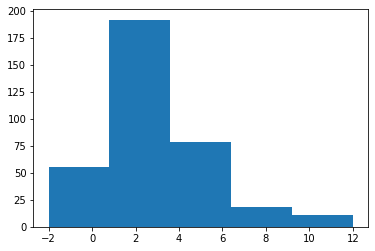

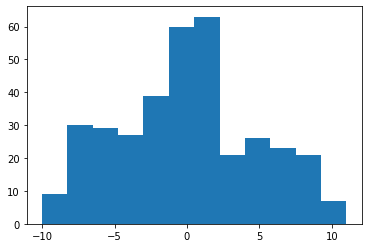

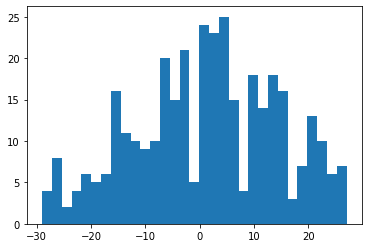

In [28]:
td = pd.read_csv("train.csv")
plt.figure()
plt.hist(pd.DatetimeIndex(td['purchase_date']).year - pd.DatetimeIndex(td['release_date']).year, bins=5) #The most frequent year: 2018

plt.figure()
plt.hist(pd.DatetimeIndex(td['purchase_date']).month - pd.DatetimeIndex(td['release_date']).month, bins=12) #The most frequest month: 6

plt.figure()
plt.hist(pd.DatetimeIndex(td['purchase_date']).day - pd.DatetimeIndex(td['release_date']).day, bins=31) #The most frequest month: 6


print('Mode of total_negative_review in Training set: ', np.nanmedian(td['total_negative_reviews'])) #Mode of total_negative_reviews: 437
print('Mode of total_positive_review in Training set: ', np.nanmedian(td['total_positive_reviews'])) #Mode of total_negative_reviews: 2809

In [29]:
test_data.at[12, 'purchase_date'] = 'Jul 21, 2018'
test_data.at[45, 'purchase_date'] = 'Mar 19, 2019'

test_data['total_negative_reviews'].fillna(437, inplace=True)
test_data['total_positive_reviews'].fillna(2809, inplace=True)

print("Total missing entrances: ", test_data[test_data.isna().any(axis=1)].shape[0])

Total missing entrances:  0


## Transformation

In [30]:
test_data = transform(test_data)

## Balance the Categories and Genres Columns

In [31]:
test_data = rebuild_categories_genres(test_data, 'test')

test_data['genres_popularity_scores'] = (mean_genres*test_data[genres_col]).sum(axis=1)
test_data['categories_popularity_scores'] = (mean_categories*test_data[categories_col]).sum(axis=1)
test_data['gen_cat_popularity_scores'] = test_data['genres_popularity_scores'] + test_data['categories_popularity_scores']

test_data['genres_rare_scores'] = (1/mean_genres*test_data[genres_col]).sum(axis=1)
test_data['categories_rare_scores'] = (1/mean_categories*test_data[categories_col]).sum(axis=1)
test_data['gen_cat_rare_scores'] = test_data['genres_rare_scores'] + test_data['categories_rare_scores']

In [32]:
test_data.head()

,price,total_positive_reviews,total_negative_reviews,purchase_year,purchase_month,release_year,release_month,wait_until_buy,Num of genres,Num of categories,...,Violent,Walking Simulator,reviews,positive_negative_ratio,genres_popularity_scores,categories_popularity_scores,gen_cat_popularity_scores,genres_rare_scores,categories_rare_scores,gen_cat_rare_scores
id,,,,,,,,,,,,,,,,,,,,,
0,3500,2607.0,1122.0,2018,10,2012,5,2350,2,2,...,0,0,3729.0,2.321460,2.360563,1.377465,3.738028,6.980610,3.426668,10.407278
1,11600,5762.0,2235.0,2019,7,2018,4,452,3,7,...,0,0,7997.0,2.576923,3.270423,3.492958,6.763380,17.238846,27.996578,45.235424
2,2100,687.0,133.0,2019,7,2017,3,848,3,3,...,0,0,820.0,5.126866,2.064789,2.371831,4.436620,20.818124,3.882941,24.701066
3,3600,67.0,39.0,2018,1,2007,7,3850,2,3,...,0,0,106.0,1.675000,1.636620,1.439437,3.076056,11.244142,9.669437,20.913579
4,3400,40344.0,3708.0,2017,2,2013,8,1282,2,7,...,0,0,44052.0,10.877325,2.360563,4.036620,6.397183,6.980610,23.312385,30.292995


In [33]:
set(test_data.columns)-set(test_data.columns)

set()

In [34]:
test_data.to_csv('test_features.csv')